In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import torchvision, cv2
from utils.visualizations import plot_samples
from utils.transforms import *
from utils.dataset import AmbientaDataset, PhysionetDataset, classes

In [9]:
dataset = PhysionetDataset(train=True)

Reading Files: [--------------------------------] 136/136, Total Samples: 12756


In [3]:
indices_per_class = {}
for i, label in enumerate(classes):
    indices = np.where(dataset.y == i)[0]
    indices_per_class[i] = indices
# print(indices_per_class)

In [4]:
sample_indices = [index for index in list(map(lambda c: random.choice(c) if len(c) > 0 else None, indices_per_class.values()))]
print(sample_indices)

[4571, 8655, 1451, 12284, 3554, 4923, 7378, 9200, None, None, None]


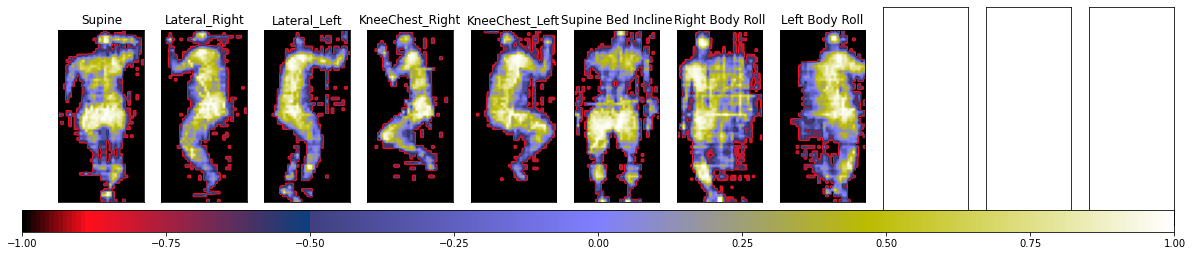

In [5]:
plot_samples(dataset, sample_indices, classes, torchvision.transforms.Compose([
        Normalize(),
        EqualizeHist(),
]))

<AxesSubplot:>

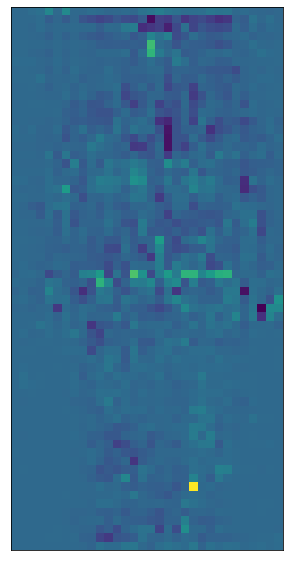

In [68]:
from utils.transforms import *
from utils.visualizations import *
import utils.transforms as tf
import utils.visualizations as vi
import importlib
importlib.reload(tf)
importlib.reload(vi)

basic_transforms = [
    Normalize(),
    EqualizeHist(),
    Blur((3, 3)),
    Threshold(lambda img: np.median(img[img > 0.0])),
]

X = dataset.x.reshape((len(dataset), -1))
plot_image(zca(X, epsilon=1e-5)[0])

#plot_samples(dataset, sample_indices, classes, transform = torchvision.transforms.Compose([
#        *basic_transforms,
#]))

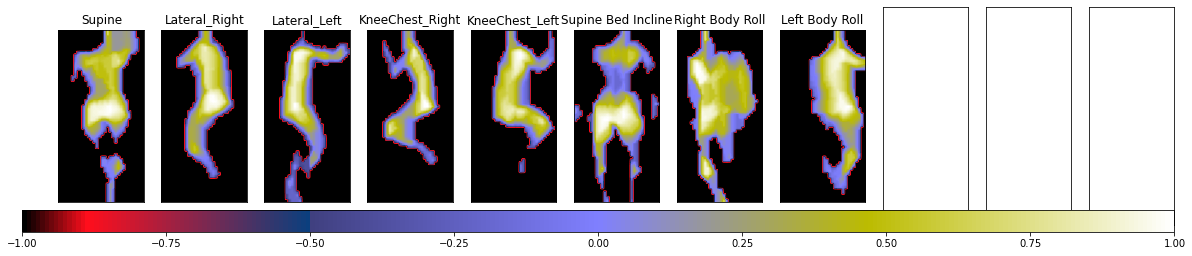

In [31]:
plot_samples(dataset, sample_indices, classes, transform = torchvision.transforms.Compose([
        *basic_transforms,
        Close((2,4), ktype=cv2.MORPH_CROSS, iterations=2),
        # Erode((2,2), ktype=cv2.MORPH_CROSS, iterations=2),
        #Close((3,3), ktype=cv2.MORPH_CROSS, iterations=2),
]))